In [1]:
from torchsummary import summary
from torch.autograd import Variable
from torch.nn import functional as F
import torch
import torchvision
import numpy as np
from torch import nn, optim

# define the model

In [2]:
class test_model(nn.Module):
    def __init__(self, num_class):
        super(test_model, self).__init__()
        self.vgg = torchvision.models.vgg16(pretrained=True)
        self.features = nn.Sequential(*list(self.vgg.children())[:-1])
        self.fc = nn.Linear(512,num_class)
        
    def forward(self,x):
        x = self.features(x)
        x = nn.AdaptiveAvgPool2d(1)(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x

#summary(model,(3,448,448))   

In [3]:
model = torch.load('CAM.pkl')
model.eval()

def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
    
#handel = model._modules.get('features').register_forward_hook(hook_feature)   

params = list(model.parameters())   #get the model's params
weight_softmax = np.squeeze(params[-2].data.cpu().numpy())  #the last full connect layer's weights
print(weight_softmax)

[[ 0.018025    0.01653172 -0.02710225 ... -0.01891181  0.03640201
   0.00133889]
 [ 0.01021021  0.01263292 -0.00804649 ... -0.03411559  0.04429753
   0.02163164]]


In [4]:
import cv2 as cv 

# return the heatmap
def returnCAM(feature_conv, weight_softmax, idx):
    # generate the class activation maps upsample to img_size
    size_upsample = img_size
    bz, nc, h, w = feature_conv.shape
    cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    cam_img = cv.resize(cam_img, size_upsample)
    return cam_img

# forward
def predict(img_path):
    img = cv.imread(img_path)
    img = cv.resize(img,img_size,interpolation=cv.INTER_AREA)
    img = img.astype(np.float32).transpose(2,0,1)
    img = img.reshape(-1,img.shape[0],img.shape[1],img.shape[2])
    img = torch.Tensor(img/255).cuda()
    cls = model(img)
    cls = cls.detach()
    return cls

# predict and draw the heatmap

cls tensor([[ 0.3533, -0.3667]], device='cuda:0')


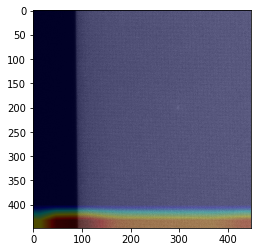

In [6]:
img_size = (448,448)
img_path = '1.jpg'
features_blobs = []

handel = model.module.features.register_forward_hook(hook_feature) # set hook
cls = predict(img_path)
handel.remove() # remove hook

img = cv.imread(img_path)
img = cv.resize(img,img_size)
CAMs = returnCAM(features_blobs[0], weight_softmax, 1)
heatmap = cv.applyColorMap(cv.resize(CAMs,img_size), cv.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5

print(f"cls {cls}")

# draw heatmap
from matplotlib import pyplot as plt 

plt.figure()
plt.imshow(result.astype(np.uint8))
plt.show()
#cv.imwrite('CAM.jpg', result)